# AnnealedVAE Model Testing Framework

In [1]:
from utils.reproducibility import set_deterministic_run, get_deterministic_dataloader

seed = 42
set_deterministic_run(seed=seed)

## 1. Imports

In [2]:
import torch
import numpy as np
import torch.utils
import matplotlib.pyplot as plt
import torch.optim as optim

import utils.visualize
from trainers import UnsupervisedTrainer
import losses
import vae_models
from datasets import get_dataset
from utils.io import find_optimal_num_workers
from metrics.utils import MetricAggregator

## 2. Configuration

In [3]:
# --- General Hyperparameters ---
model_name = 'vae_locatello'  # Name of the model architecture file
latent_dim = 10
learning_rate = 1e-4
batch_size = 64
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
rec_dist = 'bernoulli'  # Reconstruction distribution

train_step_unit = 'epoch'  # Unit for training steps ('epoch' or 'iteration')
num_train_steps = 5

# train_step_unit = 'iteration'
# num_train_steps = int(9e3) # Example for iteration-based training

In [4]:
# --- Loss Specific Hyperparameters ---
# Annealed VAE
loss_name = 'annealedvae'
loss_kwargs = {
    'C_init': 0.0,       # Starting capacity
    'C_fin': 25.0,       # Final capacity
    'gamma': 100.0,      # KL divergence weight
    'anneal_steps': 100000, # Steps for annealing capacity
    'rec_dist': rec_dist,
    'log_kl_components': True
}

## 3. Load Datasets

In [5]:
# Load 3D Shapes
Shapes3D = get_dataset("shapes3d")
shapes3d_dataset = Shapes3D(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_3dshapes = find_optimal_num_workers(shapes3d_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_3dshapes = 4

shapes3d_dataloader = get_deterministic_dataloader(dataset=shapes3d_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_3dshapes,
                                                   seed=seed,
                                                   pin_memory=True)

print(f"Loaded 3D Shapes dataset with {len(shapes3d_dataset)} samples.")

Loaded 3D Shapes dataset with 480000 samples.


In [6]:
# Load dSprites
Dsprites = get_dataset('dsprites')
dsprites_dataset = Dsprites(selected_factors='all', not_selected_factors_index_value=None)
# num_workers_dsprites = find_optimal_num_workers(dsprites_dataset, batch_size=batch_size, num_batches_to_test='all')
num_workers_dsprites = 7

dsprites_dataloader = get_deterministic_dataloader(dataset=dsprites_dataset,
                                                   batch_size=batch_size,
                                                   shuffle=True,
                                                   num_workers=num_workers_dsprites,
                                                   seed=seed,
                                                   pin_memory=True)

print(f"Loaded dSprites dataset with {len(dsprites_dataset)} samples.")

Loaded dSprites dataset with 737280 samples.


## 4. Setup Model, Loss, and Optimizer

In [7]:
def setup_components(dataset, current_loss_kwargs):
    """Instantiates model, loss function, and optimizer based on config."""
    img_size = dataset[0][0].shape
    n_data = len(dataset)

    # Instantiate Model
    model = vae_models.select(name=model_name, img_size=img_size, latent_dim=latent_dim)

    # Instantiate Loss Function
    # Note: AnnealedVAE doesn't need n_data like BetaTCVAE
    loss_fn = losses.select(loss_name, **current_loss_kwargs)

    # Instantiate Optimizer
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    print(f"--- Setup for {dataset.__class__.__name__} --- ")
    print(f"Model: {model.__class__.__name__}")
    print(f"Loss: {loss_fn.__class__.__name__} (rec_dist={rec_dist}), kwargs={current_loss_kwargs}")
    print(f"Optimizer: {optimizer.__class__.__name__}")
    print(f"---------------------------")

    return model, loss_fn, optimizer

## 5. Train and Visualize

## 5.1 - 3D Shapes

In [ ]:
# Specific loss args for 3D Shapes with AnnealedVAE
shapes3d_loss_kwargs = {
    'C_init': 0.0,
    'C_fin': 25.0, # Example value, adjust as needed
    'gamma': 1000.0, # Example value, adjust as needed
    'anneal_steps': 100000, # Example value, adjust based on training length
    'rec_dist': rec_dist
}

In [11]:
print("\n===== Training on 3D Shapes =====")
model_3dshapes, loss_fn_3dshapes, optimizer_3dshapes = setup_components(shapes3d_dataset, shapes3d_loss_kwargs)

# Assuming BaseTrainer or a similar trainer class is available
# If using BaseTrainer directly:
trainer_3dshapes = UnsupervisedTrainer(model=model_3dshapes,
                               loss_fn=loss_fn_3dshapes,
                               lr_scheduler=None,
                               optimizer=optimizer_3dshapes,
                               device=device,
                               train_step_unit=train_step_unit
                               )

training_logs_3dshapes = trainer_3dshapes.train(shapes3d_dataloader, max_steps=num_train_steps)
# print("Training Logs (3D Shapes):", training_logs_3dshapes) # Optional


===== Training on 3D Shapes =====
--- Setup for Shapes3D --- 
Model: Model
Loss: Loss (rec_dist=bernoulli), kwargs={'C_init': 0.0, 'C_fin': 25.0, 'gamma': 100.0, 'anneal_steps': 50000, 'rec_dist': 'bernoulli'}
Optimizer: Adam
---------------------------



===== Visualizing 3D Shapes Results =====
Plotting random reconstructions...


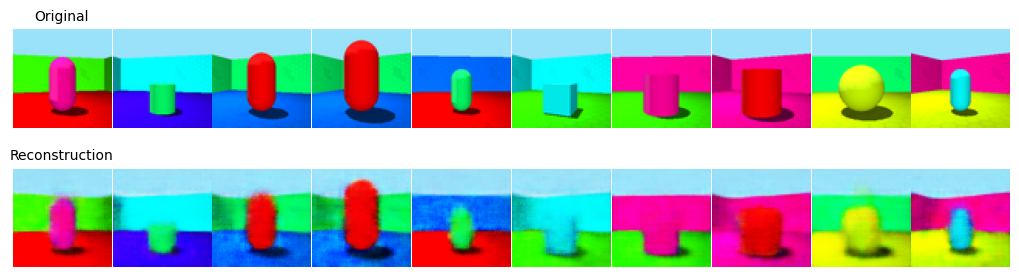

Plotting reconstructions from specific indices...


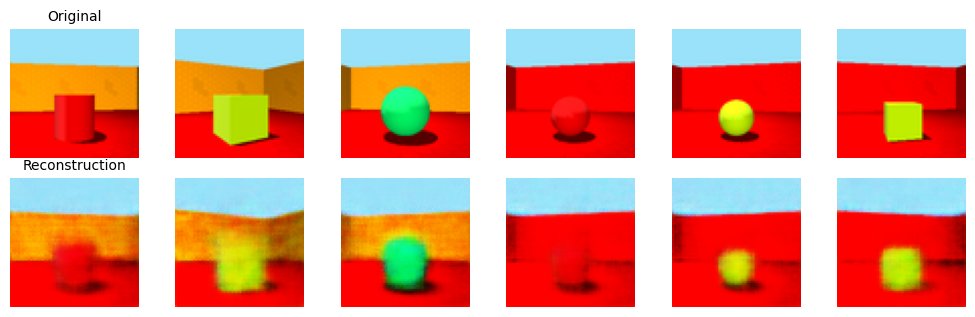

Plotting latent traversals...


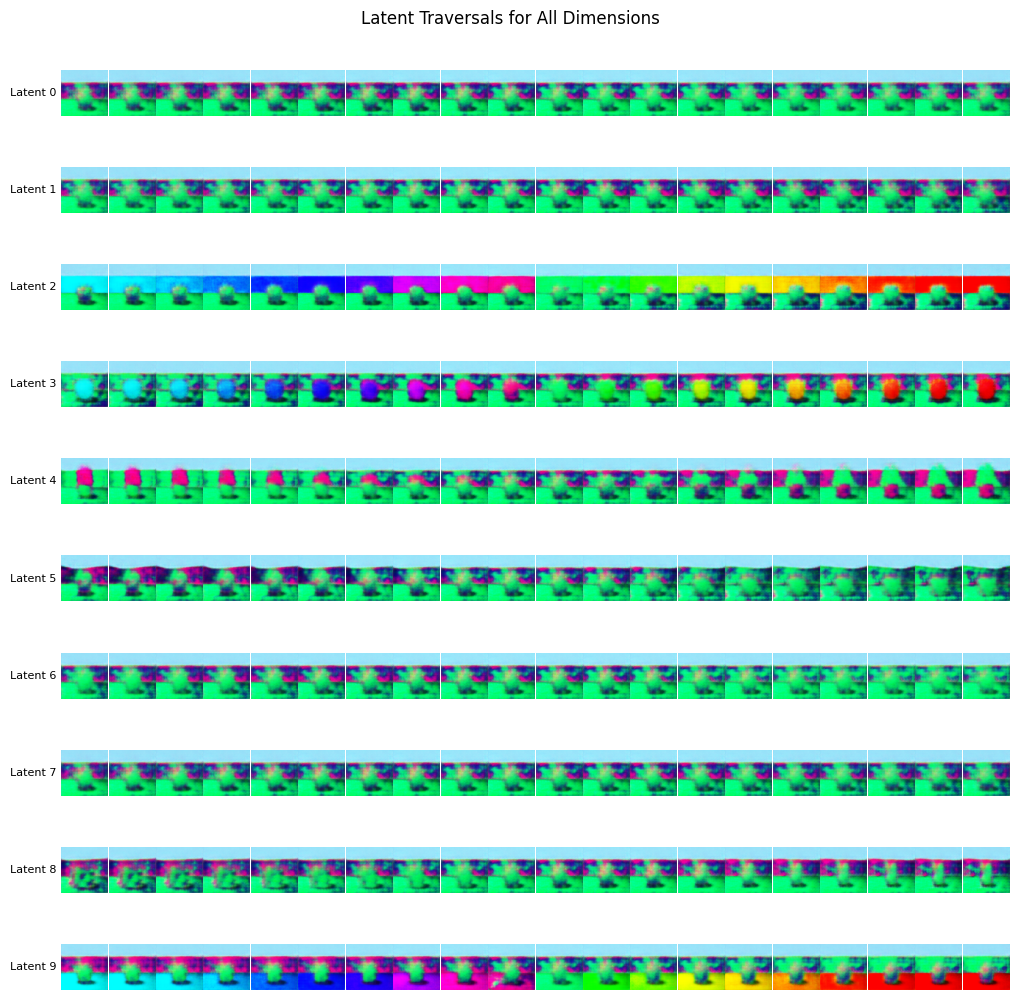

In [12]:
print("\n===== Visualizing 3D Shapes Results =====")
visualizer_3dshapes = utils.visualize.Visualizer(vae_model=model_3dshapes, dataset=shapes3d_dataset)

print("Plotting random reconstructions...")
visualizer_3dshapes.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_3dshapes = [5000, 6000, 7000, 100, 1000, 1024] # Example indices
visualizer_3dshapes.plot_reconstructions_sub_dataset(indices_3dshapes, mode='mean')
plt.show()

print("Plotting latent traversals...")
visualizer_3dshapes.plot_all_latent_traversals(num_samples=20)
plt.show()

### 5.1.1 Metric Evaluation (3D Shapes)

In [13]:
metrics_to_compute = [
    {'name': 'dci_d', 'args':{'num_train':5000, 'num_test':1000}},
    {'name': 'mig', 'args':{}}
]

In [14]:
metric_aggregator_3dshapes = MetricAggregator(metrics=metrics_to_compute)

In [15]:
print("\n===== Computing Metrics for 3D Shapes =====")
metrics_results_3dshapes = metric_aggregator_3dshapes.compute(model=model_3dshapes,
                                                              data_loader=shapes3d_dataloader,
                                                              device=device)
print("3D Shapes Metrics:", metrics_results_3dshapes)


===== Computing Metrics for 3D Shapes =====


Computing representations: 100%|██████████| 7500/7500 [00:22<00:00, 335.55it/s]


3D Shapes Metrics: {'dci_d': {'informativeness_train_errors': 0.08063333333333333, 'informativeness_test_errors': 0.212, 'informativeness_train_scores': 0.9193666666666668, 'informativeness_test_scores': 0.7879999999999999, 'disentanglement': 0.5786351530147177, 'completeness': 0.5717339326660751}, 'mig': 0.5067077887547272}


## 5.2. Train and Visualize: dSprites

### Loss args

In [19]:
# Specific loss args for dSprites with AnnealedVAE
dsprites_loss_kwargs = {
    'C_init': 0.0,
    'C_fin': 10.0,  # Example value, often lower for dSprites
    'gamma': 1000.00,
    'anneal_steps': 100000, # Example value
    'rec_dist': rec_dist
}

In [20]:
print("\n===== Training on dSprites =====")
model_dsprites, loss_fn_dsprites, optimizer_dsprites = setup_components(dsprites_dataset, dsprites_loss_kwargs)

trainer_dsprites = UnsupervisedTrainer(model=model_dsprites,
                               loss_fn=loss_fn_dsprites,
                               lr_scheduler=None,
                               optimizer=optimizer_dsprites,
                               device=device,
                               train_step_unit=train_step_unit
                               )

training_logs_dsprites = trainer_dsprites.train(dsprites_dataloader, max_steps=num_train_steps)
# print("Training Logs (dSprites):", training_logs_dsprites) # Optional


===== Training on dSprites =====
--- Setup for DSprites --- 
Model: Model
Loss: Loss (rec_dist=bernoulli), kwargs={'C_init': 0.0, 'C_fin': 10.0, 'gamma': 1000.0, 'anneal_steps': 100000, 'rec_dist': 'bernoulli'}
Optimizer: Adam
---------------------------



===== Visualizing dSprites Results =====
Plotting random reconstructions...


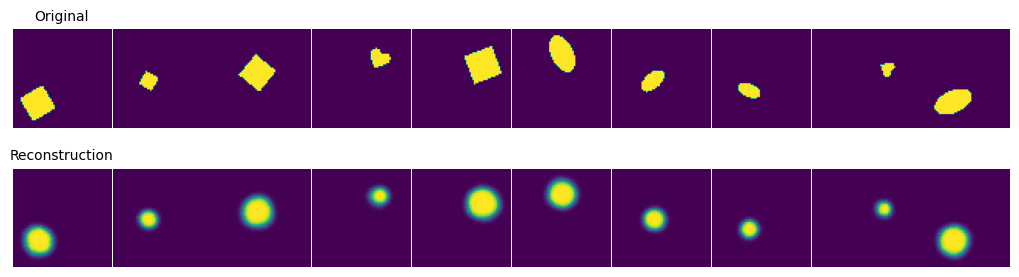

Plotting reconstructions from specific indices...


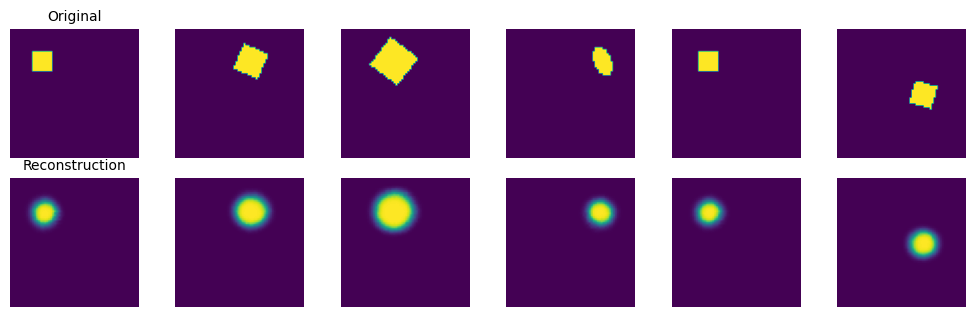

Plotting latent traversals...


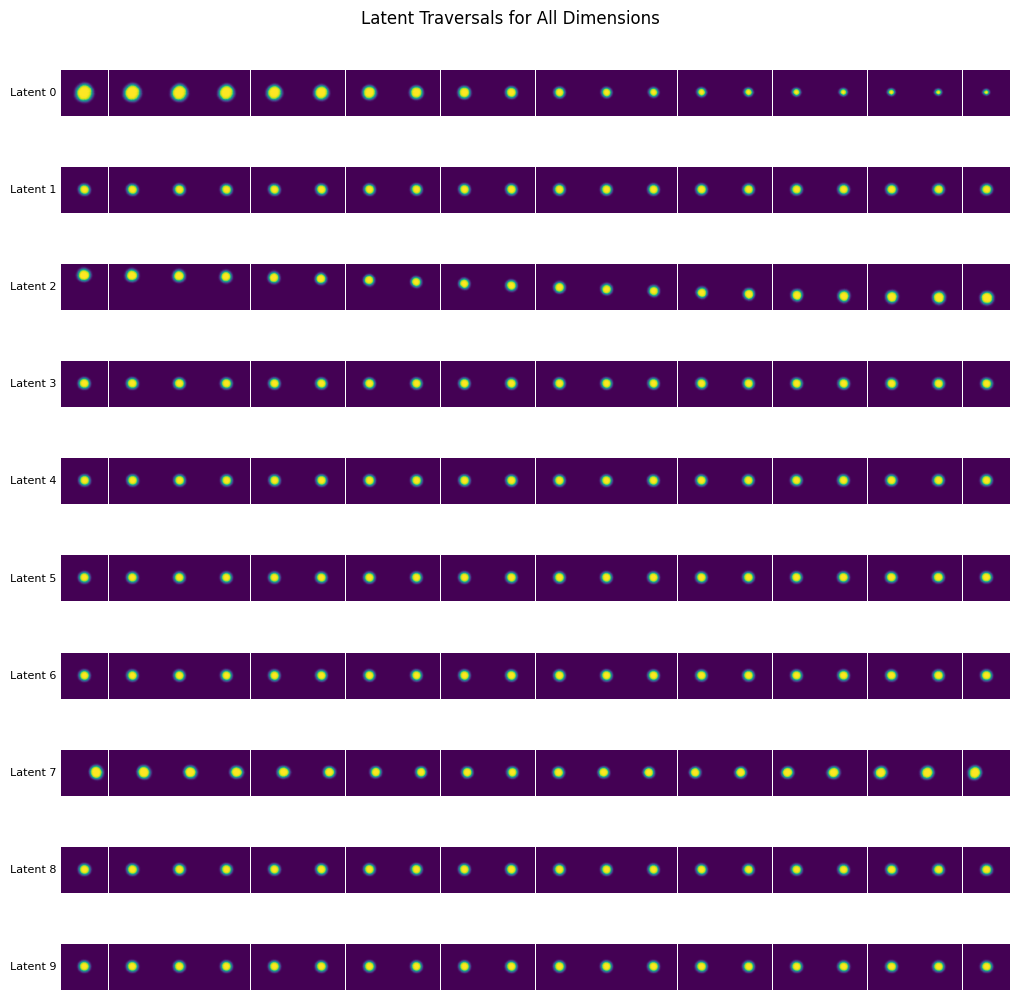

In [21]:
print("\n===== Visualizing dSprites Results =====")
visualizer_dsprites = utils.visualize.Visualizer(vae_model=model_dsprites, dataset=dsprites_dataset)

print("Plotting random reconstructions...")
visualizer_dsprites.plot_random_reconstructions(10, mode='mean')
plt.show()

print("Plotting reconstructions from specific indices...")
indices_dsprites = [0, 100000, 200000, 300000, 40000, 50000] # Example indices
visualizer_dsprites.plot_reconstructions_sub_dataset(indices_dsprites, mode='mean')
plt.show()

print("Plotting latent traversals...")
visualizer_dsprites.plot_all_latent_traversals(num_samples=20)
plt.show()

### 5.2.1 Metric Evaluation (dSprites)

In [22]:
metric_aggregator_dsprites = MetricAggregator(metrics=metrics_to_compute)

In [ ]:
print("\n===== Computing Metrics for dSprites =====")
metrics_results_dsprites = metric_aggregator_dsprites.compute(model=model_dsprites,
                                                            data_loader=dsprites_dataloader,
                                                            device=device)
print("dSprites Metrics:", metrics_results_dsprites)


===== Computing Metrics for dSprites =====


Computing representations: 100%|██████████| 11520/11520 [00:24<00:00, 475.95it/s]
